# INTRODUÇÃO

    Dada a alta volatilidade e discrepâncias de qualidade no ensino brasileiro, muitos se questionam a respeito do 
    rendimento na principal forma de entrada ao ensino superior, o ENEM. Este projeto visa, segundo dados
    característicos de cada escola, analisar microdados existentes no INEP para, por meio de padrões e
    probabilidades, prever uma nota média no ENEM segundo diversos fatores. Caracterizando ou não a existência de
    correlações entre singularidades e um bom rendimento na prova.

    O projeto conta com as seguintes variáveis explicativas, que auxiliarião na construção de probabilidades: Ano 
    de aplicação do ENEM, estado que se encontra a escola, local (urbano ou rural), porte da escola e taxa de 
    aprovação dos alunos no ensino médio.

# MINERANDO DADOS

    Visto que a análise toma em conta apenas 5 features, foi necessária a limpeza da base de dados, remoção de 
    colunas indesejadas e dados irrelevantes, para não haver interferência nos valores das probabilidades e 
    garantir uma análise significativa ao projeto.

In [1]:
import os
import scipy.stats as stats
from scipy.stats import t, norm, probplot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt, ceil

microdados = pd.read_excel('microdados.xlsx')

microdados.head()

,NU_ANO,CO_UF_ESCOLA,SG_UF_ESCOLA,CO_MUNICIPIO_ESCOLA,NO_MUNICIPIO_ESCOLA,CO_ESCOLA_EDUCACENSO,NO_ESCOLA_EDUCACENSO,TP_DEPENDENCIA_ADM_ESCOLA,TP_LOCALIZACAO_ESCOLA,NU_MATRICULAS,...,NU_MEDIA_RED,NU_MEDIA_OBJ,NU_MEDIA_TOT,INSE,PC_FORMACAO_DOCENTE,NU_TAXA_PERMANENCIA,NU_TAXA_APROVACAO,NU_TAXA_REPROVACAO,NU_TAXA_ABANDONO,PORTE_ESCOLA
0,2007,11,RO,1100205,Porto Velho,11000058,CENTRO DE ENSINO CLASSE A,4,1,144,...,NaN,NaN,69.03,NaN,NaN,NaN,91.9,8.1,0.0,Maior que 90 alunos
1,2006,11,RO,1100205,Porto Velho,11000058,CENTRO DE ENSINO CLASSE A,4,1,184,...,NaN,NaN,57.82,NaN,NaN,NaN,NaN,NaN,NaN,Maior que 90 alunos
2,2005,11,RO,1100205,Porto Velho,11000058,CENTRO DE ENSINO CLASSE A,4,1,220,...,NaN,NaN,64.83,NaN,NaN,NaN,86.5,12.4,1.1,Maior que 90 alunos
3,2008,11,RO,1100205,Porto Velho,11000058,CENTRO DE ENSINO CLASSE A,4,1,186,...,72.16,60.02,NaN,NaN,NaN,NaN,90.3,9.7,0.0,Maior que 90 alunos
4,2007,11,RO,1100205,Porto Velho,11000171,CENTRO EDUCACIONAL MOJUCA,4,1,19,...,NaN,NaN,58.84,NaN,NaN,NaN,74.2,21.0,4.8,De 1 a 30 alunos


# Limpeza da Base de Dados

In [2]:
# Filtrando a base de dados, deixando somente as colunas relacionadas as features escolhidas para o projeto. Desse forma, tornando mais fácil a manipulação das colunas para a análise exploratória dos dados.
dados = microdados.loc[:,['NU_MEDIA_TOT','NU_ANO', 'SG_UF_ESCOLA','TP_LOCALIZACAO_ESCOLA','PORTE_ESCOLA','NU_TAXA_APROVACAO']]

In [3]:
# Renomeando as colunas para facilitar as análises e entendimento das respectivas colunas

dados.rename(columns={'NU_MEDIA_TOT':'MEDIA_TOTAL_ENEM'}, inplace=True)
dados.rename(columns={'NU_ANO':'ANO'}, inplace=True)
dados.rename(columns={'SG_UF_ESCOLA':'UF_ESCOLA'}, inplace=True)
dados.rename(columns={'TP_LOCALIZACAO_ESCOLA':'LOCAL'}, inplace=True)
dados.rename(columns={'PORTE_ESCOLA':'TAMANHO'}, inplace=True)
dados.rename(columns={'NU_TAXA_APROVACAO':'TAXA_APROVACAO'}, inplace=True)

In [4]:
# Adequando cada coluna com seus tipos de dados

dados['TAMANHO'] = dados['TAMANHO'].astype('category')
dados['UF_ESCOLA'] = dados['UF_ESCOLA'].astype('category')
dados['LOCAL'] = dados['LOCAL'].astype('category')


dados['LOCAL'] = dados['LOCAL'].cat.rename_categories(['Urbano', 'Rural'])


dados = dados.dropna(axis=0, how='any')
dados.head(70)

,MEDIA_TOTAL_ENEM,ANO,UF_ESCOLA,LOCAL,TAMANHO,TAXA_APROVACAO
0,69.03,2007,RO,Urbano,Maior que 90 alunos,91.9
2,64.83,2005,RO,Urbano,Maior que 90 alunos,86.5
4,58.84,2007,RO,Urbano,De 1 a 30 alunos,74.2
6,35.44,2005,RO,Urbano,De 1 a 30 alunos,69.3
7,48.46,2005,RO,Urbano,De 61 a 90 alunos,86.5
...,...,...,...,...,...,...
137,46.66,2007,RO,Urbano,De 61 a 90 alunos,68.9
140,45.79,2007,RO,Rural,De 31 a 60 alunos,80.5
142,38.22,2005,RO,Urbano,De 61 a 90 alunos,78.2
144,42.66,2007,RO,Urbano,Maior que 90 alunos,76.2


# Análise Exploratória 

    Diante de vastas informações, nosso objetivo partiu-se da compreensão dos valores das features segundo suas 
    relações com o target principal. A partir de gráficos de dispersão, histogramas e estatísticas iniciamos a 
    análise exploratória dos dados, para compreensão de quais fatores apresentariam uma maior influência diante
    dos demais. 

## 1. Média Enem X Ano de Aplicação

Correlação entre média total no ENEM e ano de aplicação: 0.361921333480833


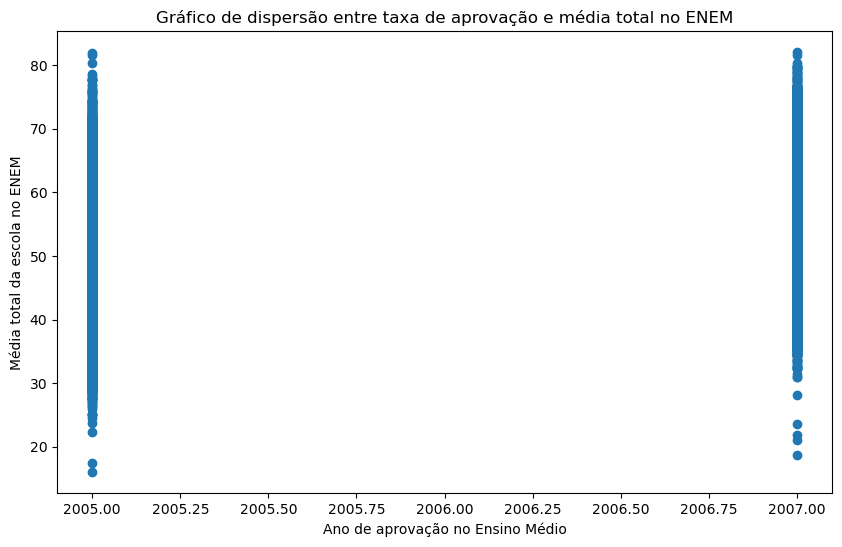

In [31]:
# Análise de target quantitativo e feature quantitativa

# Grau de correlação entre ano de aplicação e média total no ENEM
print(f'Correlação entre média total no ENEM e ano de aplicação: {dados.ANO.corr(dados.MEDIA_TOTAL_ENEM)}')

plt.figure(figsize=(10, 6))
plt.scatter(dados.ANO, dados.MEDIA_TOTAL_ENEM)
plt.title('Gráfico de dispersão entre taxa de aprovação e média total no ENEM')
plt.xlabel('Ano de aprovação no Ensino Médio')
plt.ylabel('Média total da escola no ENEM');

## 2. Média Enem X Taxa Aprovação no Ensino Médio

Correlação entre média total no ENEM e taxa de aprovação no Ensino Médio: 0.47909482648601454


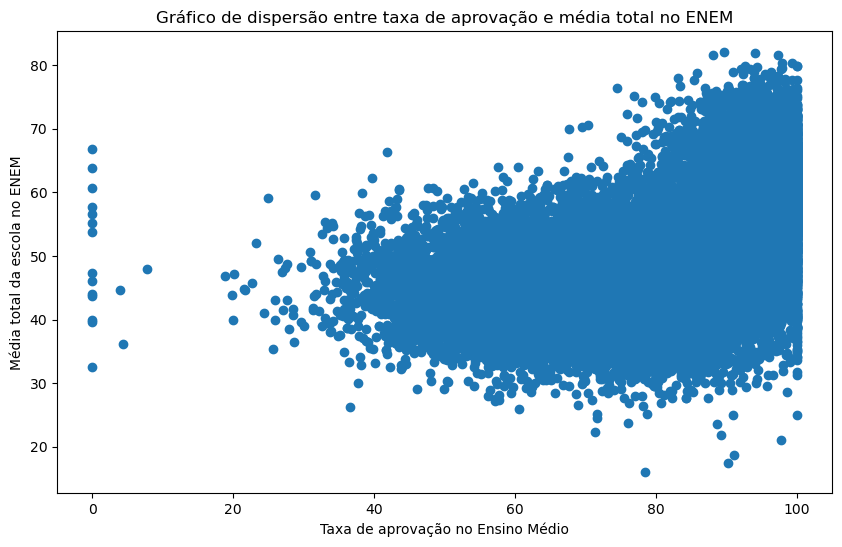

In [71]:
# Análise de target quantitativo e feature quantitativa

# Grau de correlação entre taxa de aprovação no Ensino Médio e média total no ENEM
print(f'Correlação entre média total no ENEM e taxa de aprovação no Ensino Médio: {dados.TAXA_APROVACAO.corr(dados.MEDIA_TOTAL_ENEM)}')

plt.figure(figsize=(10, 6))
# Gráfico de dispersão entre taxa de aprovação e média total no ENEM
plt.scatter(dados.TAXA_APROVACAO, dados.MEDIA_TOTAL_ENEM)
plt.title('Gráfico de dispersão entre taxa de aprovação e média total no ENEM')
plt.xlabel('Taxa de aprovação no Ensino Médio')
plt.ylabel('Média total da escola no ENEM');

    Visto que são dados reais e informações empíricas, a análise dos dados ultrapassa seu valor numérico e infere
    as disparidades de ensino e facilidades de alcance de notas maiores segundo as condições vividas pelo
    estudante.
    Tomando em conta, por exemplo, o gráfico de dispersão de aprovação no ensino médio e nota média no ENEM, é 
    evidente e intuitivo que o ensino base tem uma importância altíssima na preparação para o ensino superior, 
    deste modo, é possível perceber que o índice de notas maiores depreendem-se das escolas que apresentam uma 
    maior taxa de aprovação do ensino médio.

## 3. Média Enem X Região do País

In [72]:
#Separando os estados brasileiros de acordo com sua região no país para facilitar análise por histogramas

# Dicionário de estado por região para facilitar a divisão
regioes = {
    'Norte': ['AC', 'AM', 'AP', 'PA', 'RO', 'RR', 'TO'],
    'Nordeste': ['AL', 'BA', 'CE', 'MA', 'PB', 'PE', 'PI', 'RN', 'SE'],
    'Centro-Oeste': ['DF', 'GO', 'MS', 'MT'],
    'Sudeste': ['ES', 'MG', 'RJ', 'SP'],
    'Sul': ['PR', 'RS', 'SC']}

# Percorrendo as regiões e criando nova coluna no dataframe com a região específica de cada estado
for regiao, estados in regioes.items():
    dados.loc[dados['UF_ESCOLA'].isin(estados), 'REGIAO'] = regiao
    
dados.head()

,MEDIA_TOTAL_ENEM,ANO,UF_ESCOLA,LOCAL,TAMANHO,TAXA_APROVACAO,REGIAO
0,69.03,2007,RO,Urbano,Maior que 90 alunos,91.9,Norte
2,64.83,2005,RO,Urbano,Maior que 90 alunos,86.5,Norte
4,58.84,2007,RO,Urbano,De 1 a 30 alunos,74.2,Norte
6,35.44,2005,RO,Urbano,De 1 a 30 alunos,69.3,Norte
7,48.46,2005,RO,Urbano,De 61 a 90 alunos,86.5,Norte


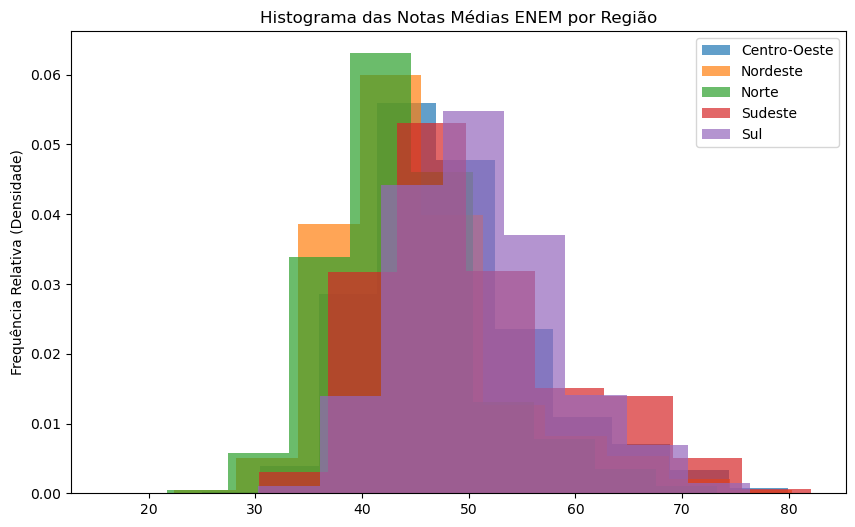

In [73]:
# Plotando em um histograma só
regiao_nota = dados.groupby('REGIAO')['MEDIA_TOTAL_ENEM']

plt.figure(figsize=(10, 6))
plt.xlabel('Nota Média ENEM')
regiao_nota.plot(kind='hist', alpha=0.7, legend=True, density = True) 
plt.title('Histograma das Notas Médias ENEM por Região')
plt.ylabel('Frequência Relativa (Densidade)');

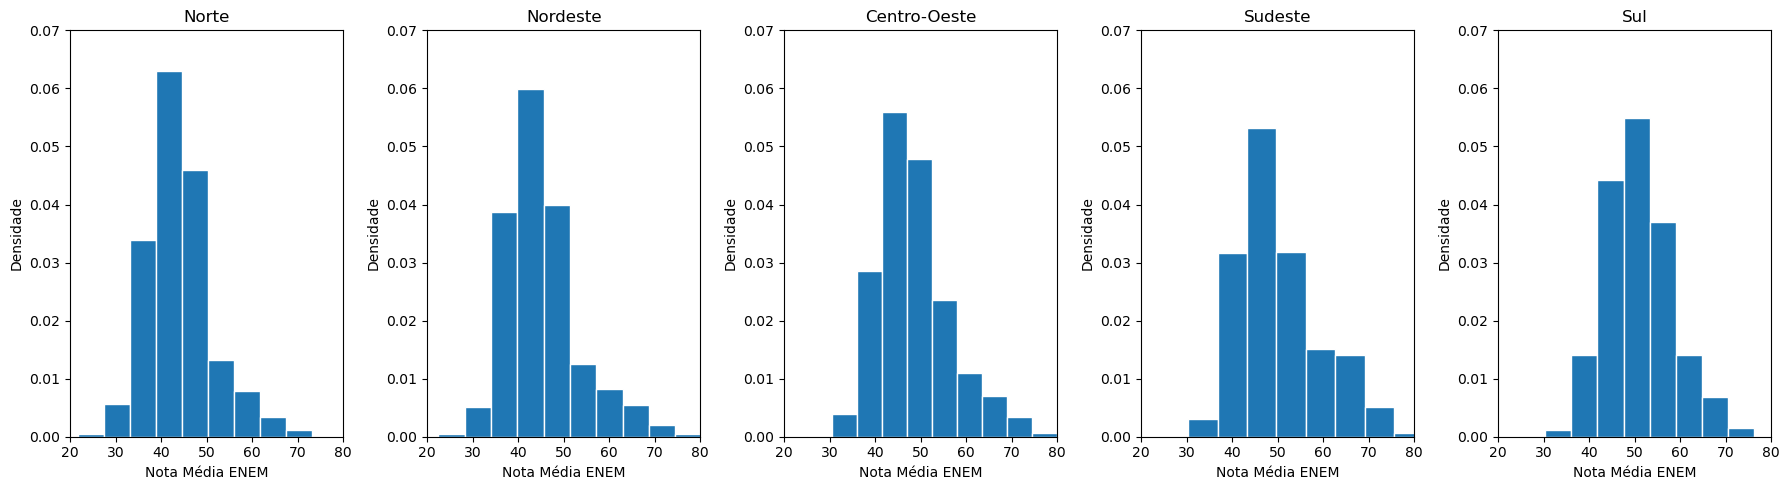

In [74]:
# Separado em um histograma por região
dados_norte = dados.loc[dados.REGIAO=='Norte', :]
dados_nordeste = dados.loc[dados.REGIAO=='Nordeste', :]
dados_centro_oeste = dados.loc[dados.REGIAO=='Centro-Oeste', :]
dados_sudeste = dados.loc[dados.REGIAO=='Sudeste', :]
dados_sul = dados.loc[dados.REGIAO=='Sul', :]

plt.figure(figsize=(18,5)) 

plt.subplot(1,5,1)
plt.title('Norte')
plt.xlabel('Nota Média ENEM')
plt.ylabel('Densidade')
plt.xlim(20,80)
plt.ylim(0,0.07)
plt.hist(dados_norte.MEDIA_TOTAL_ENEM, density = True, edgecolor = 'white')

plt.subplot(1,5,2)
plt.title('Nordeste')
plt.xlabel('Nota Média ENEM')
plt.ylabel('Densidade')
plt.xlim(20,80)
plt.ylim(0,0.07)
plt.hist(dados_nordeste.MEDIA_TOTAL_ENEM, density = True, edgecolor = 'white')

plt.subplot(1,5,3)
plt.title('Centro-Oeste')
plt.xlabel('Nota Média ENEM')
plt.ylabel('Densidade')
plt.xlim(20,80)
plt.ylim(0,0.07)
plt.hist(dados_centro_oeste.MEDIA_TOTAL_ENEM, density = True, edgecolor = 'white')

plt.subplot(1,5,4)
plt.title('Sudeste')
plt.xlabel('Nota Média ENEM')
plt.ylabel('Densidade')
plt.xlim(20,80)
plt.ylim(0,0.07)
plt.hist(dados_sudeste.MEDIA_TOTAL_ENEM, density = True, edgecolor = 'white')

plt.subplot(1,5,5)
plt.title('Sul')
plt.xlabel('Nota Média ENEM')
plt.ylabel('Densidade')
plt.xlim(20,80)
plt.ylim(0,0.07)
plt.hist(dados_sul.MEDIA_TOTAL_ENEM, density = True, edgecolor = 'white')


plt.tight_layout();

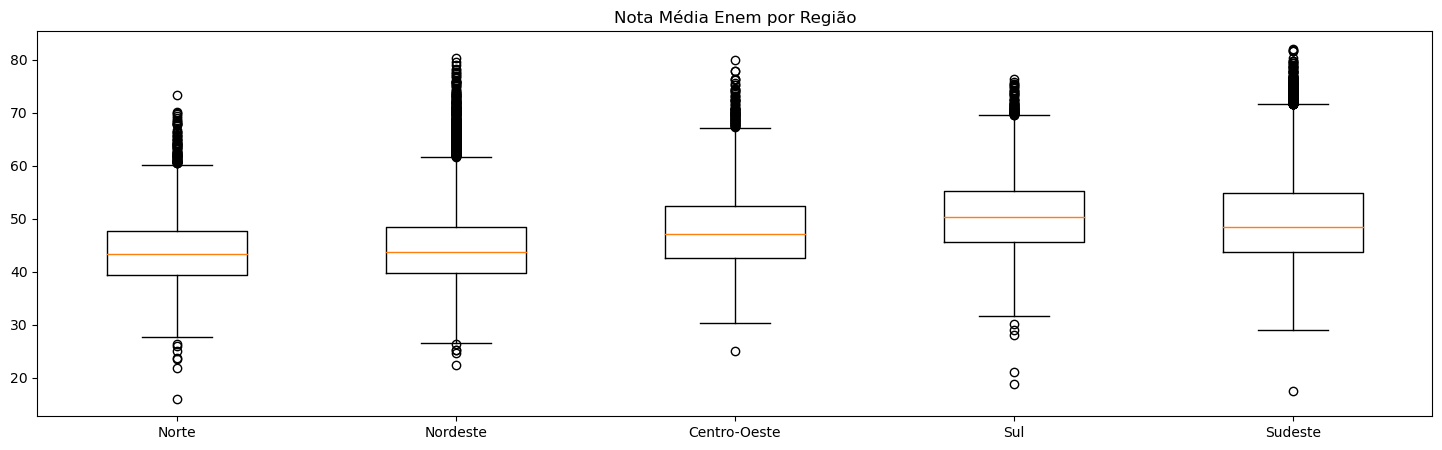

In [75]:
plt.figure(figsize=(18,5))

plt.boxplot([dados_norte.MEDIA_TOTAL_ENEM, dados_nordeste.MEDIA_TOTAL_ENEM, dados_centro_oeste.MEDIA_TOTAL_ENEM, dados_sul.MEDIA_TOTAL_ENEM, dados_sudeste.MEDIA_TOTAL_ENEM], labels = ['Norte', 'Nordeste', 'Centro-Oeste', 'Sul', 'Sudeste'])
plt.title('Nota Média Enem por Região');

In [76]:

print("Estatísticas da Média Total do ENEM por Região")
dados.groupby('REGIAO')['MEDIA_TOTAL_ENEM'].describe()


Estatísticas da Média Total do ENEM por Região


,count,mean,std,min,25%,50%,75%,max
REGIAO,,,,,,,,
Centro-Oeste,2620.0,48.413286,8.019566,24.96,42.65,47.115,52.4525,79.90
Nordeste,7708.0,45.180711,8.089487,22.41,39.69,43.740,48.4900,80.32
Norte,2232.0,44.063414,7.150650,16.01,39.35,43.260,47.7525,73.26
Sudeste,15060.0,50.243669,8.907691,17.40,43.71,48.430,54.8400,82.04
Sul,4861.0,50.946577,7.288648,18.77,45.67,50.370,55.2300,76.33


    Ademais, explorando o gráfico de maiores médias segundo a região que a escola pertence, é possível observar o 
    padrão das notas do ensino do sul e sudeste seguindo uma distribuição normal e simétrica, com indíces de
    rendimento bons. Tal fato pode ser devido ao salto que, principalmente as regiões no sul e sudeste do país, 
    vem tendo a partir de 2005 no índice de desenvolvimento do ensino básico (IDEB), que é o principal formador de
    alunos passíveis a notas altas no enem como pôde ser visto no gráfico analisado anteriormente. 
    
    Segundo os dados análisados nos boxplots do rendimento por região também é passível observar que as maiores
    médias advém de estados presentes no sul e sudeste do país, entretanto, é possível observar que a região com
    valores mais aberrantes é o nordeste, isso pode ser devido ao alto investimento desta região em ensino
    havendo as melhores escolas para se estudar, sendo, atualmente, o líder nos índices de educação. Porém nota-se um cenário desigual, visto que os resultados ainda não afetam todos os estudantes, caracterizando os valores aberrantes encontrados. 
    
        link<https://agenciabrasil.ebc.com.br/radioagencia-nacional/educacao/audio/2020-09/ensino-medio-tem-o-maior-salto-no-ideb-desde-2005>

## 4. Média Enem X Local (Urbano ou Rural)

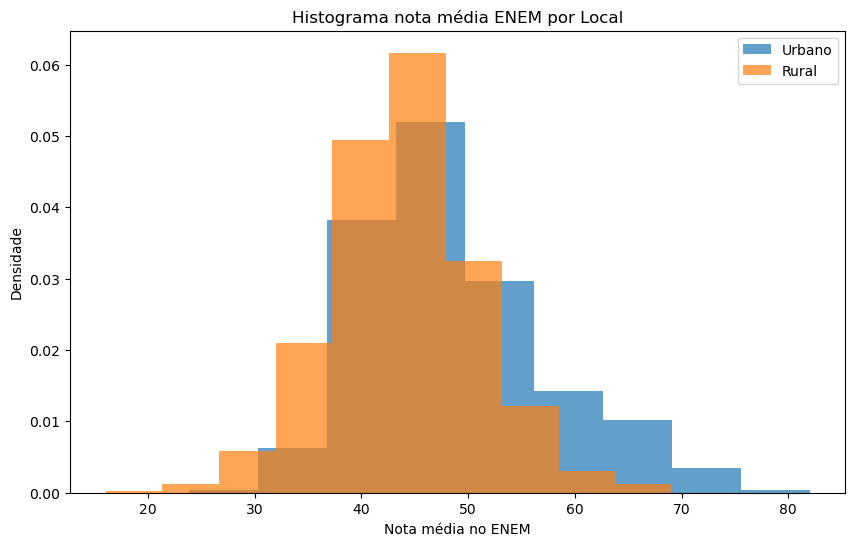

In [78]:
local_nota = dados.groupby('LOCAL')['MEDIA_TOTAL_ENEM']

plt.figure(figsize=(10, 6))
local_nota.plot(kind='hist', alpha=0.7, legend=True, density=True) # Com densidade

plt.title('Histograma nota média ENEM por Local')
plt.xlabel('Nota média no ENEM')
plt.ylabel('Densidade');

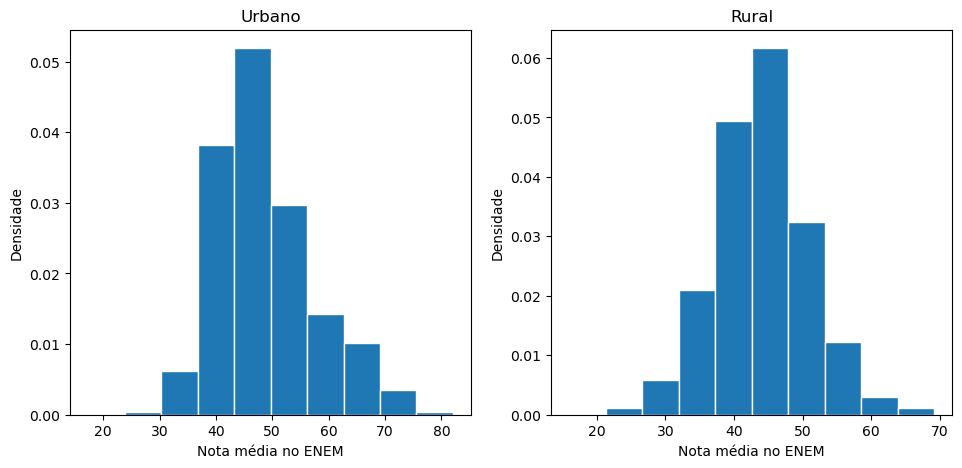

In [79]:
dados_urbano = dados.loc[dados['LOCAL'] == 'Urbano']
dados_rural = dados.loc[dados['LOCAL'] == 'Rural']


plt.figure(figsize=(30,5)) 
plt.subplot(1,5,1)
plt.hist(dados_urbano['MEDIA_TOTAL_ENEM'], density = True, edgecolor = 'white')

plt.title('Urbano')
plt.xlabel('Nota média no ENEM')
plt.ylabel('Densidade')


plt.subplot(1,5,2)
plt.hist(dados_rural['MEDIA_TOTAL_ENEM'], density = True, edgecolor = 'white')

plt.title('Rural')
plt.xlabel('Nota média no ENEM')
plt.ylabel('Densidade');


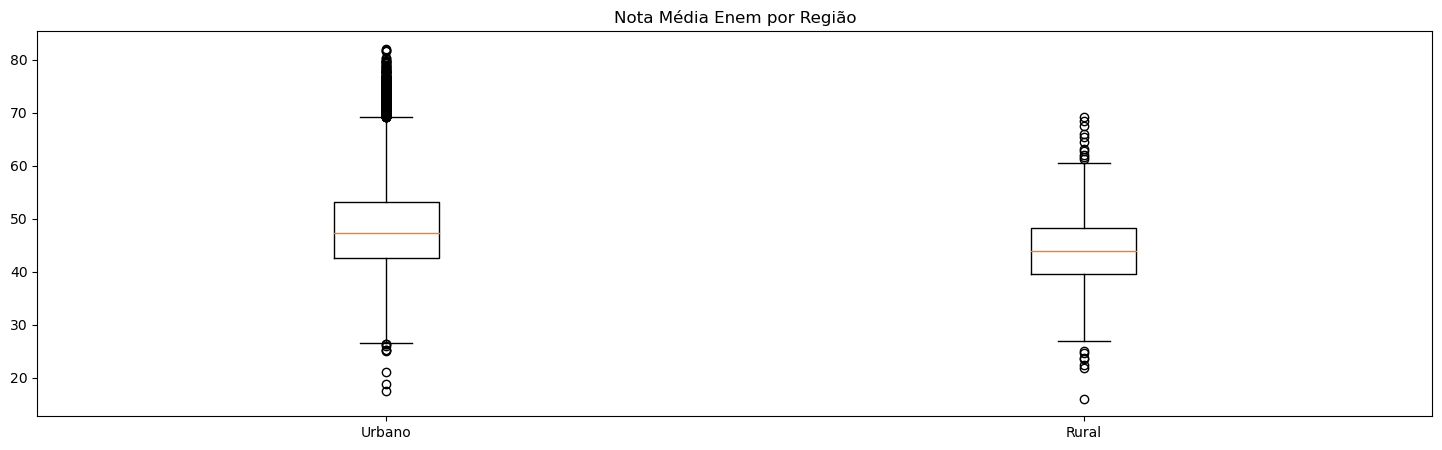

In [80]:
plt.figure(figsize=(18,5))

plt.boxplot([dados_urbano.MEDIA_TOTAL_ENEM, dados_rural.MEDIA_TOTAL_ENEM], labels = ['Urbano', 'Rural'])
plt.title('Nota Média Enem por Região');

In [81]:
print("Estatísticas da Média Total do ENEM por Local (Urbano ou Rural)")
dados.groupby('LOCAL')['MEDIA_TOTAL_ENEM'].describe()

Estatísticas da Média Total do ENEM por Local (Urbano ou Rural)


,count,mean,std,min,25%,50%,75%,max
LOCAL,,,,,,,,
Urbano,31541.0,48.712647,8.683990,17.40,42.50,47.21,53.19,82.04
Rural,940.0,43.958138,6.875386,16.01,39.61,43.91,48.16,69.14


    Partindo para a análise do rendimento a partir da localização escolar, torna-se evidente o que muitas vezes 
    é dado como intuitivo, as maiores notas são alcançadas por escolas presentes no meio urbano e que possuem
    um contato rápido e eficiente com as contemporaneidades, o que tem um peso muito grande para esta prova, visto
    que o ENEM prioriza perguntas que envolvam conhecimentos atuais e situações que estão em vigor nos anos
    próximos a prova.
    
    link2<https://www.educamaisbrasil.com.br/educacao/noticias/nordeste-e-lider-nos-indices-de-educacao-aponta-censo>
    

## 5. Média Enem X Tamanho Escola

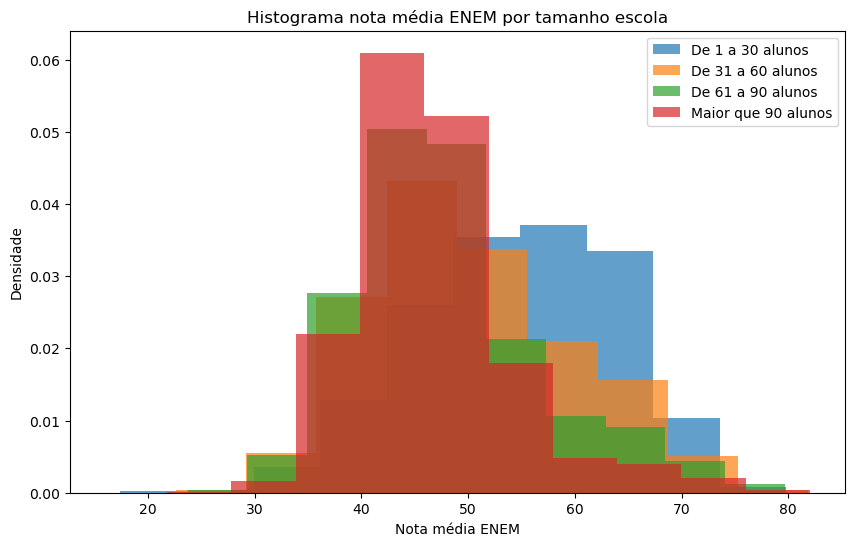

In [86]:
tamanho = dados.groupby('TAMANHO')['MEDIA_TOTAL_ENEM']

plt.figure(figsize=(10, 6))
tamanho.plot(kind='hist', alpha=0.7, legend=True, density=True)
plt.title('Histograma nota média ENEM por tamanho escola')
plt.xlabel('Nota média ENEM')
plt.ylabel('Densidade');

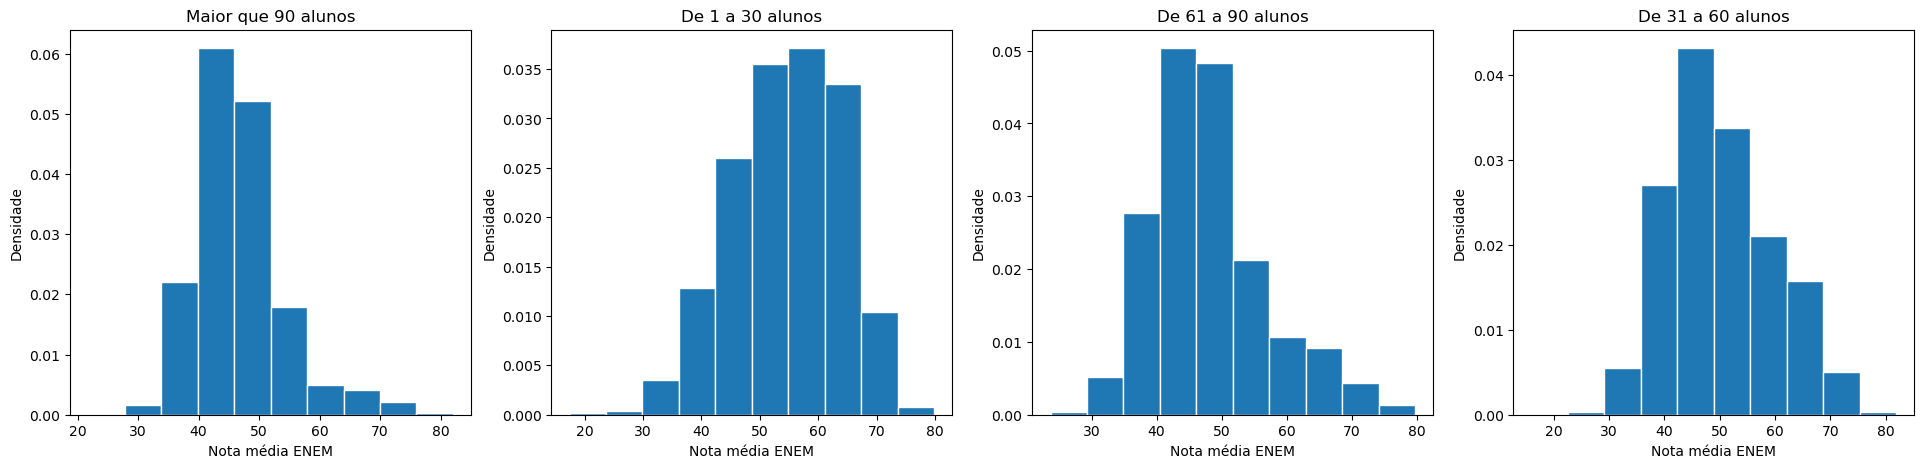

In [87]:
dados_90 = dados.loc[dados['TAMANHO'] == 'Maior que 90 alunos']
dados_1_30 = dados.loc[dados['TAMANHO'] == 'De 1 a 30 alunos']
dados_61_90 = dados.loc[dados['TAMANHO'] == 'De 61 a 90 alunos']
dados_31_60 = dados.loc[dados['TAMANHO'] == 'De 31 a 60 alunos']

plt.figure(figsize=(30,5))

plt.subplot(1,5,2)
plt.hist(dados_1_30['MEDIA_TOTAL_ENEM'], density=True, edgecolor = 'white')
plt.title('De 1 a 30 alunos')
plt.xlabel('Nota média ENEM')
plt.ylabel('Densidade')

plt.subplot(1,5,4)
plt.hist(dados_31_60['MEDIA_TOTAL_ENEM'], density=True, edgecolor = 'white')
plt.title('De 31 a 60 alunos')
plt.xlabel('Nota média ENEM')
plt.ylabel('Densidade')


plt.subplot(1,5,3)
plt.hist(dados_61_90['MEDIA_TOTAL_ENEM'], density=True, edgecolor = 'white')
plt.title('De 61 a 90 alunos')
plt.xlabel('Nota média ENEM')
plt.ylabel('Densidade')

plt.subplot(1,5,1)
plt.hist(dados_90['MEDIA_TOTAL_ENEM'], density=True, edgecolor = 'white')
plt.title('Maior que 90 alunos')
plt.xlabel('Nota média ENEM')
plt.ylabel('Densidade');

In [88]:
print("Estatísticas da Média Total do ENEM por Tamanho da Escola")
dados.groupby('TAMANHO')['MEDIA_TOTAL_ENEM'].describe()


Estatísticas da Média Total do ENEM por Tamanho da Escola


,count,mean,std,min,25%,50%,75%,max
TAMANHO,,,,,,,,
De 1 a 30 alunos,3784.0,54.556456,9.251326,17.40,47.920,55.17,61.7725,79.82
De 31 a 60 alunos,6863.0,50.248335,9.437491,16.01,43.175,48.93,56.6800,81.89
De 61 a 90 alunos,5498.0,47.930668,8.809041,23.71,41.820,46.63,52.0100,79.67
Maior que 90 alunos,16336.0,46.703445,7.289088,21.79,41.840,45.72,50.0425,82.04


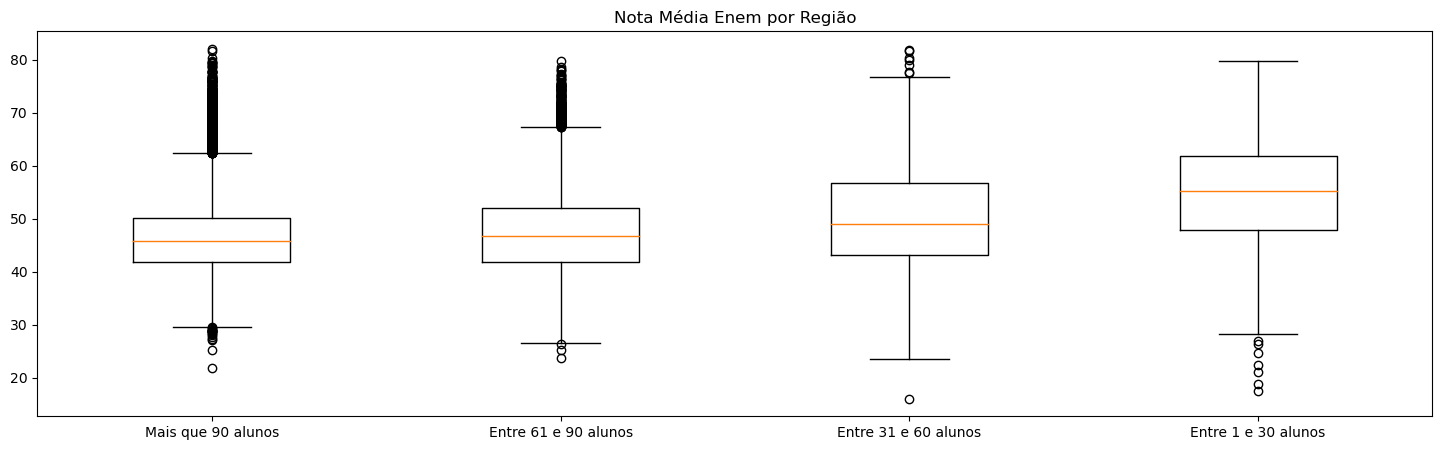

In [89]:
plt.figure(figsize=(18,5))

plt.boxplot([dados_90.MEDIA_TOTAL_ENEM, dados_61_90.MEDIA_TOTAL_ENEM, dados_31_60.MEDIA_TOTAL_ENEM, dados_1_30.MEDIA_TOTAL_ENEM], labels = ['Mais que 90 alunos', 'Entre 61 e 90 alunos', 'Entre 31 e 60 alunos', 'Entre 1 e 30 alunos'])
plt.title('Nota Média Enem por Região');

    Por fim, há características importantes evidentes na última análise de rendimento de acordo com tamanho
    escolar. Tal situação é, atualmente, muito explorada no ensino produtivo e qualitativo, no qual é visível
    que há um maior entendimento e aprovação do ensino nas escolas que conseguem oferecer o máximo de atenção
    para o aluno. Essa afirmativa pode ser observada através dos boxplots e histogramas construídos, nos quais as 
    escolas com menor quantidade de alunos apresenta uma média mais alta de notas e uma menor quantidade de
    números aberrantes, o qual é o processo contrário em escolas com grandes quantidades de alunos, que contém 
    muitas médias anormais e pouca padronização do rendimento.